# Modelo de Machine Learning, aprendizaje supervisado

### Preparar datos, entrenar y evaluar modelo

Época [1/5], Pérdida: 1.2070
Época [2/5], Pérdida: 0.8118
Época [3/5], Pérdida: 0.6504
Época [4/5], Pérdida: 0.7580
Época [5/5], Pérdida: 0.5274
Exactitud de validación: 60.00%
[[ 7 15  3]
 [ 0 26  1]
 [ 3  8 12]]


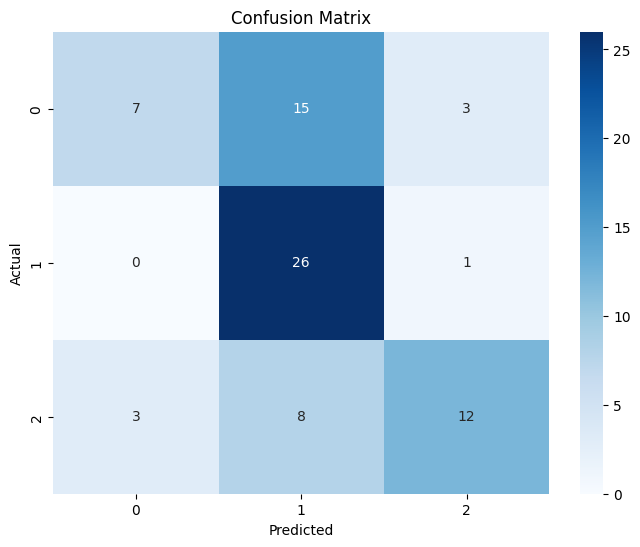

Classification Report:
               precision    recall  f1-score   support

     mediana       0.70      0.28      0.40        25
       mucha       0.53      0.96      0.68        27
      normal       0.75      0.52      0.62        23

    accuracy                           0.60        75
   macro avg       0.66      0.59      0.57        75
weighted avg       0.65      0.60      0.57        75



In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Preparar los datos

# Directorio que contiene las imágenes
data_dir = "../imagenes_entrenamiento"

# Tamaño de los lotes de datos
batch_size = 8

# Transformaciones que se aplican a las imágenes
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionar las imágenes a 224x224 píxeles
    transforms.ToTensor(),  # Convertir las imágenes a tensores
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalizar los colores
])

# Cargar las imágenes y asignar etiquetas automáticamente según los nombres de las carpetas
dataset = datasets.ImageFolder(data_dir, transform=transform)

# Dividir el conjunto de datos en entrenamiento y validación
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Crear cargadores de datos para el entrenamiento y la validación
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 2. Entrenar el modelo

# Utilizar ResNet-18 preentrenada
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Modificar la capa final para clasificar en 3 clases
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 3)

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Número de épocas de entrenamiento
num_epochs = 5
for epoch in range(num_epochs):
    model.train()  # Establecer el modo de entrenamiento
    running_loss = 0.0
    for inputs, labels in train_loader:  # Iterar sobre los lotes de datos
        optimizer.zero_grad()  # Limpiar los gradientes
        outputs = model(inputs)  # Hacer la predicción
        loss = criterion(outputs, labels)  # Calcular la pérdida
        loss.backward()  # Propagar hacia atrás
        optimizer.step()  # Actualizar los parámetros
        running_loss += loss.item()
    print(f"Época [{epoch+1}/{num_epochs}], Pérdida: {running_loss/len(train_loader):.4f}")

# 3. Evaluar el modelo

model.eval()  # Establecer el modo de evaluación
correct = 0
total = 0
all_labels = []
all_preds = []
with torch.no_grad():  # Desactivar el cálculo de gradientes
    for inputs, labels in val_loader:  # Iterar sobre los lotes de datos de validación
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # Obtener la clase con la mayor probabilidad
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
print(f"Exactitud de validación: {100 * correct / total:.2f}%")

# Generar la matriz de confusión
cm = confusion_matrix(all_labels, all_preds)
print(cm)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Calcular el reporte de clasificación
report = classification_report(all_labels, all_preds, target_names=dataset.classes)
print("Classification Report:\n", report)


# Procesamiento de datos

### Predecir ya con el modelo entrenado
Se crea una nueva base de datos como resultado del analisis del modelo de machine learning.

In [2]:
import os
import pandas as pd
from PIL import Image
import random

# Función para generar un número aleatorio flotante de 2 dígitos dentro de un rango específico
def generar_peso_extra(clase_ropa):
    if clase_ropa == "normal":
        return round(random.uniform(0.5, 1.5), 2)
    elif clase_ropa == "mediana":
        return round(random.uniform(1.5, 2.5), 2)
    else:
        return round(random.uniform(2.5, 5), 2)

# Función para predecir la clase de ropa y crear un nuevo archivo de Excel
def predict_images(excel_file, new_excel_file):
    """Función para predecir la clase de todas las imágenes en un archivo de Excel y guardar los resultados en un nuevo archivo."""
    # Cargar el archivo de Excel en un DataFrame
    df = pd.read_excel(excel_file)

    # Iterar sobre cada fila del DataFrame
    for index, row in df.iterrows():
        image_path = row["IMAGEN_PASAJERO"]
        if pd.notnull(image_path) and os.path.isfile(image_path):
            # Verificar si la ruta es un archivo válido
            image = Image.open(image_path)
            image = transform(image).unsqueeze(0)
            model.eval()
            with torch.no_grad():
                output = model(image)
            _, predicted = torch.max(output, 1)
            class_name = dataset.classes[predicted.item()]
            print(f'La persona en la imagen "{os.path.basename(image_path)}" tiene "{class_name}" ropa.')

            # Generar el peso extra aleatorio según la clase de ropa
            peso_extra = generar_peso_extra(class_name)

            # Actualizar las columnas "ROPA" y "PESO_KG_EXTRA" en el DataFrame
            df.loc[index, "ROPA"] = class_name
            df.loc[index, "PESO_KG_EXTRA"] = peso_extra

    # Guardar el nuevo DataFrame en un nuevo archivo de Excel
    df.to_excel(new_excel_file, index=False)

# Ruta hacia la base de datos de los pasajeros
predict_images("../pasajeros/bd_pasajeros.xlsx", "../resultado_analisis/bd_resultados.xlsx")

La persona en la imagen "pasajero1.jpg" tiene "mucha" ropa.
La persona en la imagen "pasajero2.webp" tiene "mediana" ropa.
La persona en la imagen "pasajero3.webp" tiene "mucha" ropa.
La persona en la imagen "pasajero4.jpg" tiene "mediana" ropa.
La persona en la imagen "pasajero5.webp" tiene "mediana" ropa.
La persona en la imagen "pasajero6.webp" tiene "mediana" ropa.
La persona en la imagen "pasajero7.jpg" tiene "mucha" ropa.
La persona en la imagen "pasajero8.jpg" tiene "mucha" ropa.
La persona en la imagen "pasajero9.jpg" tiene "mediana" ropa.
La persona en la imagen "pasajero10.jpg" tiene "mediana" ropa.
La persona en la imagen "pasajero11.jpg" tiene "mucha" ropa.
La persona en la imagen "pasajero12.jpg" tiene "normal" ropa.
La persona en la imagen "pasajero13.jpg" tiene "mucha" ropa.
La persona en la imagen "pasajero14.jpg" tiene "mucha" ropa.
La persona en la imagen "pasajero15.jpg" tiene "mucha" ropa.
La persona en la imagen "pasajero16.jpg" tiene "mediana" ropa.
La persona en 

# Analisís del cruze final de datos. 

### Objetivo de este analisis: 
es mostrar un analisis sencillo pero esclarecedor de los datos, tomando en cuenta el cruze final de las dos bases de datos mas importantes, es decir, la del trafico aereo y la de pasajeros.


C:\Users\iEspa\AppData\Local\Temp\ipykernel_7384\1173465078.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  porcentaje_exceso_peso = pd.concat([porcentaje_exceso_peso, pd.DataFrame({


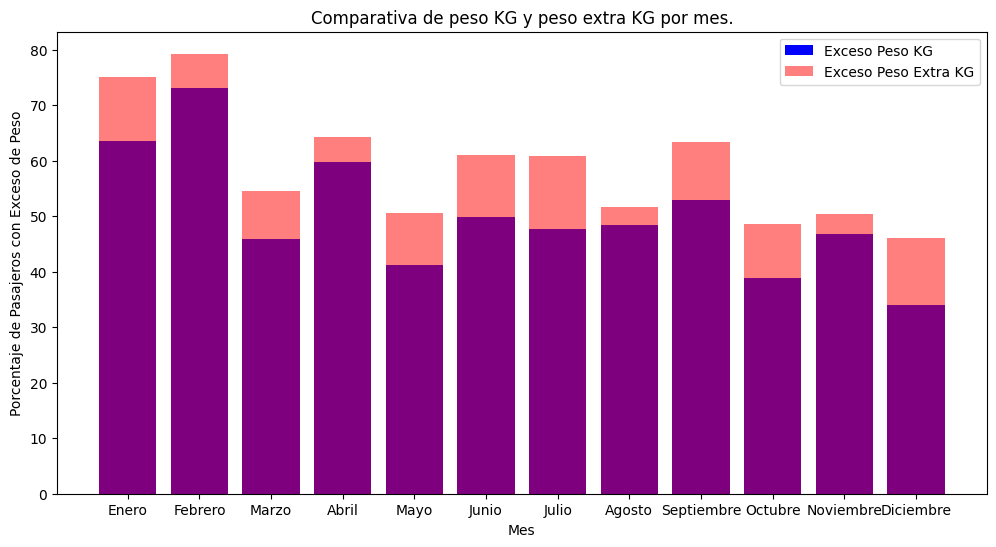

C:\Users\iEspa\AppData\Local\Temp\ipykernel_7384\1173465078.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  promedio_peso_extra_por_mes = df_final.groupby('Mes')['PESO_EXTRA_AVION'].mean().reindex(orden_meses)


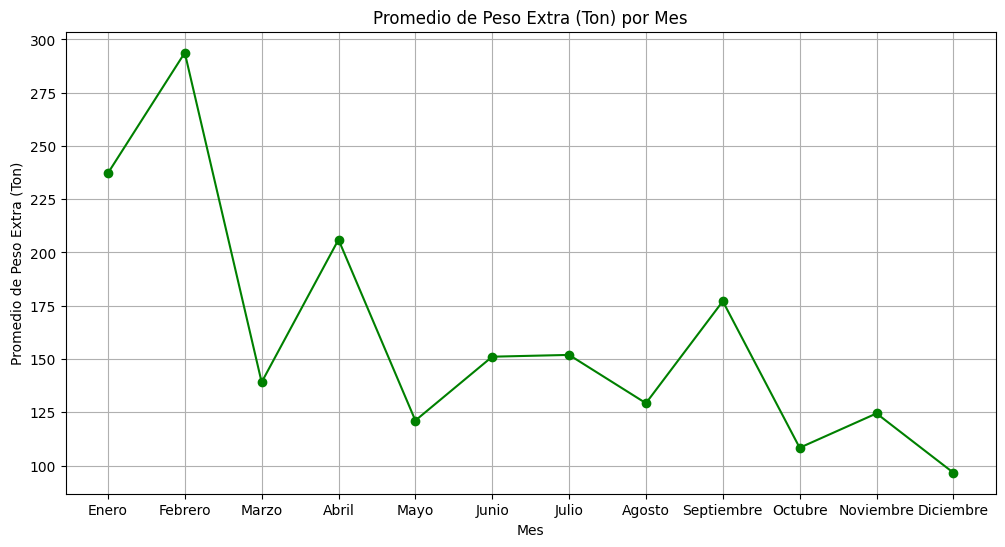

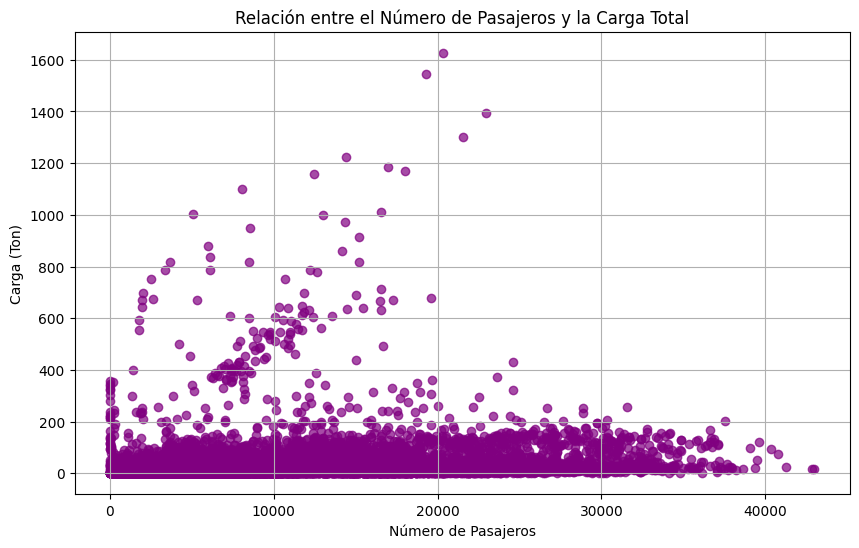

C:\Users\iEspa\AppData\Local\Temp\ipykernel_7384\1173465078.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sumas_por_mes = df_final.groupby('Mes')[['PESO_P_AVION', 'PESO_EXTRA_AVION']].sum()


<Figure size 1200x600 with 0 Axes>

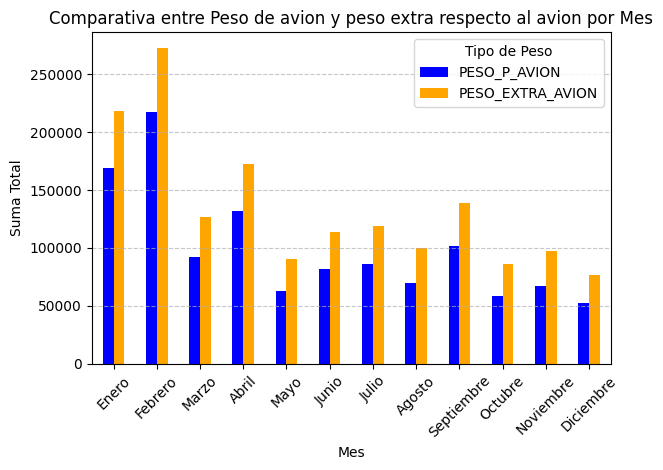

In [2]:
# Importar las librerías necesarias
import pandas as pd
import matplotlib.pyplot as plt
import os

# Definir la ruta del archivo final
folder_1 = '../db_Final'
archivo_final = os.path.join(folder_1, 'db_Final.xlsx')

# Cargar el archivo Excel final
df_final = pd.read_excel(archivo_final)

# Definir el orden de los meses
orden_meses = ["Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio",
               "Julio", "Agosto", "Septiembre", "Octubre", "Noviembre", "Diciembre"]

# Convertir la columna 'Mes' a tipo categórico con el orden definido
df_final['Mes'] = pd.Categorical(df_final['Mes'], categories=orden_meses, ordered=True)

# Porcentaje de Exceso de Peso por Mes
porcentaje_exceso_peso = pd.DataFrame(columns=['Mes', 'Exceso_peso_kg', 'Exceso_peso_extra_kg'])

for mes in df_final['Mes'].unique():
    total_pasajeros = len(df_final[df_final['Mes'] == mes])
    exceso_peso_kg = len(df_final[(df_final['Mes'] == mes) & (df_final['Exceso_peso_kg'] == True)]) / total_pasajeros * 100
    exceso_peso_extra_kg = len(df_final[(df_final['Mes'] == mes) & (df_final['Exceso_peso_extra_kg'] == True)]) / total_pasajeros * 100
    
    porcentaje_exceso_peso = pd.concat([porcentaje_exceso_peso, pd.DataFrame({
        'Mes': [mes],
        'Exceso_peso_kg': [exceso_peso_kg],
        'Exceso_peso_extra_kg': [exceso_peso_extra_kg]
    })], ignore_index=True)

# Ordenar los meses para que aparezcan en orden cronológico
porcentaje_exceso_peso['Mes'] = pd.Categorical(porcentaje_exceso_peso['Mes'], categories=orden_meses, ordered=True)
porcentaje_exceso_peso = porcentaje_exceso_peso.sort_values('Mes')

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(porcentaje_exceso_peso['Mes'], porcentaje_exceso_peso['Exceso_peso_kg'], color='b', label='Exceso Peso KG')
plt.bar(porcentaje_exceso_peso['Mes'], porcentaje_exceso_peso['Exceso_peso_extra_kg'], color='r', alpha=0.5, label='Exceso Peso Extra KG')

# Añadir etiquetas y título
plt.xlabel('Mes')
plt.ylabel('Porcentaje de Pasajeros con Exceso de Peso')
plt.title('Comparativa de peso KG y peso extra KG por mes.')
plt.legend()

# Mostrar el gráfico
plt.show()

# Promedio de peso extra por mes
promedio_peso_extra_por_mes = df_final.groupby('Mes')['PESO_EXTRA_AVION'].mean().reindex(orden_meses)

# Crear el gráfico de líneas
plt.figure(figsize=(12, 6))
plt.plot(promedio_peso_extra_por_mes.index, promedio_peso_extra_por_mes.values, marker='o', linestyle='-', color='green')
plt.xlabel('Mes')
plt.ylabel('Promedio de Peso Extra (Ton)')
plt.title('Promedio de Peso Extra (Ton) por Mes')
plt.grid(True)
plt.show()

sumas_por_mes = df_final.groupby('Mes')[['PESO_P_AVION', 'PESO_EXTRA_AVION']].sum()

plt.figure(figsize=(12, 6))
sumas_por_mes.plot(kind='bar', color=['blue', 'orange'])
plt.xlabel('Mes')
plt.ylabel('Suma Total')
plt.title('Comparativa entre Peso de avion y peso extra respecto al avion por Mes')
plt.xticks(rotation=45)
plt.legend(title='Tipo de Peso')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()